<a href="https://colab.research.google.com/github/mohamedsayed18/Pose_estimation/blob/master/Posenet_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Modules to use
import numpy as np
import tensorflow as tf
import cv2 
from matplotlib import pyplot as plt

In [2]:
#load my drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load the model
interpreter = tf.lite.Interpreter("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/posenet.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()   # the input shape
output_details = interpreter.get_output_details()   # the output shape
floating_model = input_details[0]['dtype'] == np.float32  # type of output

In [0]:
# Load the image
def load_image(image):
    """reshape and convert image to fit the model"""
    img = cv2.imread(image)     # Load images
    img = cv2.resize(img, (257, 257), interpolation=cv2.INTER_LINEAR)  #  resize
    img = img = (np.float32(img) - 127.5) / 127.5   # change image to float and normalize
    img = img.reshape((1, 257, 257, 3))    # resize
    return img

In [0]:
imge = cv2.imread("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/data/pose.jpg") 
img = load_image("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/data/pose.jpg")
interpreter.set_tensor(input_details[0]['index'], img)    # feed the image to model
interpreter.invoke()

In [6]:
# The output of the model
output_data = interpreter.get_tensor(output_details[0]['index'])    # the heatmap output
output_offset = interpreter.get_tensor(output_details[1]['index'])  # the offset output

heatmap = output_data[0]
offsets = output_offset[0]
print(heatmap.shape)
print(offsets.shape)

(9, 9, 17)
(9, 9, 34)


### How to parse the output to get the keypoints
1.  A sigmoid activation is done on the heatmap to get the scores.
2.  Find the max element(confidence score) in each heatmap layer.
3. Find the offset vector of the same element(max element)
4. To get the key points, the keypoint positions is multiplied by the stride then added to the offset vector<br/>
keypointPositions = hm_positions * 32 + offset_vectors



In [0]:
def get_keypoints(heatmap, offsets):
  """
  Get the keypoint output
  params:
  heatmap: the heatmap of the output
  offsets: the offset vectors of the output
  return:
  keypointPositions: list of the (x, y) position of every keypoint
  """
  # store some variables
  confidences =[]
  offset_vectors=[]
  hm_positions = []

  scores = sigmoid(heatmap)   # sigmoid
  for k in range(17):   # no. of keypoints
    x,y = np.unravel_index(np.argmax(scores[:,:,k]), scores[:,:,k].shape)   # find the max 
    hm_positions.append([x,y])
    confidences.append(scores[x,y,k])
    offset_vectors.append([offsets[x,y,k], offsets[x,y,k+17]])
  keypointPositions = np.add(np.array(hm_positions) * 32, offset_vectors)

  return confidences, keypointPositions

In [0]:
def sigmoid(a):
  """sigmoid function"""
  return 1/(1 + np.exp(-a))

In [0]:
con, kp = get_keypoints(heatmap, offsets)

In [0]:
def draw_on(img, con, kp):
  """Draw on image"""
  img2 = cv2.resize(img, (257,257))   # make a copy and resize
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  # draw circles:
  for i in range(len(kp)):
    if con[i]>0.5:
      x, y = int(kp[i,1]), int(kp[i,0])
      centre = (x,y)  
      cv2.circle(img2, centre, 3, (255,0,0), -1)
  return img2

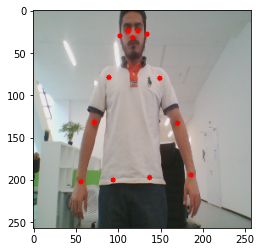

In [11]:
out = draw_on(imge, con, kp)
plt.imshow(out)

In [0]:
# Load the model
model = tf.lite.Interpreter("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/posenet.tflite")
model.allocate_tensors()
input_details = model.get_input_details()   # the input shape
output_details = model.get_output_details()   # the output shape

In [15]:
# with different photo
# Load the image and convert it to the right size and format
img = cv2.imread("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/data/balance.jpg")
img2 = load_image("/content/drive/My Drive/innopolis/1st year courses/2nd term/CV/GP/data/balance.jpg")
model.set_tensor(input_details[0]['index'], img2)    # feed the image to model

# The output of the model
output_data2 = model.get_tensor(output_details[0]['index'])[0]    # the heatmap output
output_offset2 = model.get_tensor(output_details[1]['index'])[0]  # the offset output

print(output_data2.shape)
print(output_offset2.shape)

model.invoke()

(9, 9, 17)
(9, 9, 34)


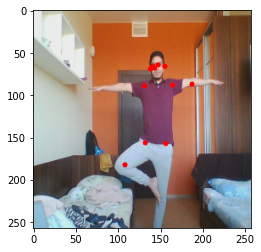

In [16]:
con2, kp2 = get_keypoints(output_data2, output_offset2)
new_image = draw_on(img, con2, kp2)
new_image.shape
plt.imshow(new_image)